## Image reconstruction with Minimum Cost Flows

_Combinatorial Optimization course, FEE CTU in Prague. Created by [Industrial Informatics Department](http://industrialinformatics.fel.cvut.cz)._

In this exercise, we will demonstrate the use of Minimum Cost Flow Problem for 2D image reconstructon from 1D projections. Simalar (but more complax) approaches are used for [X-ray crystallography](https://en.wikipedia.org/wiki/X-ray_crystallography).

_References:_
 - R.  K.  Ahuja,  T.  L.  Magnanti,  and  J.  B.  Orlin,
Network  Flows:   Theory,  Algorithms,  andApplications.  Prentice Hall; United States Ed edition, 1993.
 -  K. J. Batenburg,  “A network flow algorithm for reconstructing binary images from discretex-rays,”J. Math. Imaging Vis., vol. 27, no. 2, pp. 175–191, 2007.


In [49]:
import sys
import gurobipy as g
import matplotlib.pyplot as plt
%matplotlib inline

First we load our input data. These are our four projections and suggesting sequence of projections:

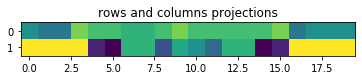

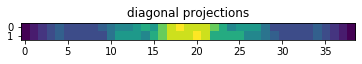

['A', 'D', 'C', 'R', 'D', 'A', 'R', 'C', 'A', 'C', 'C', 'R', 'R', 'D', 'D', 'C', 'C', 'A', 'A', 'R', 'R', 'D']


In [56]:
n = 0
k = 0

I = {}

sumR = ()
sumC = ()
sumA = ()
sumD = ()
seq = ()

for i, line in enumerate(open('mobile_input.txt', 'r')):
    if i == 0:
        n, k = list(map(int, line.split()))
    if len(line) > 0:
        if i == 1:
            sumR = list(map(int, line.split()))
        if i == 2:
            sumC = list(map(int, line.split()))
        if i == 3:
            sumA = list(map(int, line.split()))
        if i == 4:
            sumD = list(map(int, line.split()))
        if i == 5:
            seq = line.split()
            
plt.imshow([sumR, sumC])
plt.title('rows and columns projections')
plt.show()
plt.title('diagonal projections')
plt.imshow([sumA, sumD])
plt.show()
print(seq)

Next, we compute matricies of indicies that serve as basis for constructing graphs for each possible pair of projections.

In [57]:
mapping = {'R': sumR, 'C': sumC, 'A': sumA, 'D': sumD}

indicesR = {}
indicesC = {}
indicesD = {}
indicesA = {}

F = {}  # resulting image

for i in range(n):
    for j in range(n):
        indicesR[i, j] = i
        indicesC[i, j] = j
    for j in range(n):
        indicesD[i, j] = n - i + j - 1
        indicesA[i, j] = i + j - 1 + 1
        F[i, j] = 0


indices = {'R': indicesR, 'C': indicesC, 'A': indicesA, 'D': indicesD}

Now data is prepared and we let run algorithm to see individual iterations:

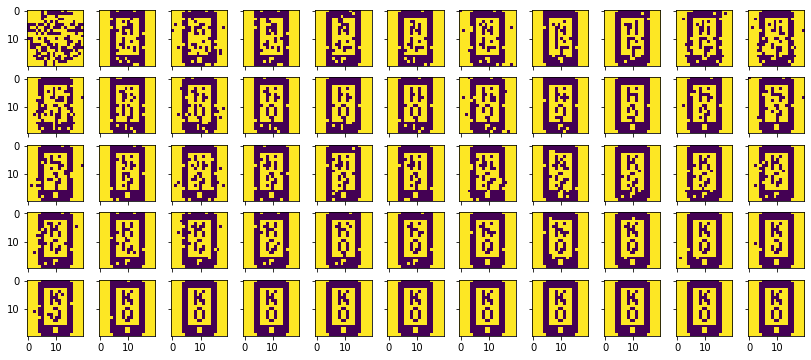

In [58]:
def mincostflow(G, l, u, b, c):
    # here, we will use Linear Programming to solve Minimum Cost Flow Problem. 
    # In practice, you would use specialized optimized algorithm, which is part of your homework 3.
    
    m = g.Model()
    e = {}
    for i, j in G:
        e[i, j] = m.addVar(vtype=g.GRB.CONTINUOUS, lb=l[i, j], ub=u[i, j], obj=c[i, j])

    m.update()

    for k, v in enumerate(b):
        m.addConstr(v == -g.quicksum([e[i, k] for i, j in G if j == k]) + g.quicksum([e[k, j] for i, j in G if i == k]))
    m.params.outputflag = 0
    m.optimize()

    if m.Status == g.GRB.OPTIMAL:
        flow = {}
        for i, j in G:
            flow[i, j] = int(round(e[i, j].x))

        return flow, int(round(m.objVal))
    else:
        return None, 0
    
    
fig, axs = plt.subplots(k, int(len(seq)/2), figsize=(14, 6))

for ic in range(k):
    q = 0
    while q < len(seq):
        pair = (seq[q], seq[q+1])

        sumK = mapping[pair[0]]
        sumL = mapping[pair[1]]

        G = []
        b = mapping[pair[0]] + [-k for k in mapping[pair[1]]]
        l = {}
        u = {}
        c = {}

        indicesK = indices[pair[0]]
        indicesL = indices[pair[1]]

        from_matrix = {}
        to_matrix = {}

        for i in range(n):
            for j in range(n):
                from_node = indicesK[i, j]
                to_node = indicesL[i, j]

                G += [(from_node, to_node + len(sumK))]
                c[from_node, to_node + len(sumK)] = 1 - F[i, j]
                u[from_node, to_node + len(sumK)] = 1
                l[from_node, to_node + len(sumK)] = 0

                from_matrix[from_node, to_node + len(sumK)] = i
                to_matrix[from_node, to_node + len(sumK)] = j

        flow, fval = mincostflow(G, l, u, b, c)

        I = [0]*n
        for i in range(n):
            I[i] = [0]*n

        for i, j in from_matrix.keys():
            F[from_matrix[i, j], to_matrix[i, j]] = flow[i, j]
            I[from_matrix[i, j]][to_matrix[i, j]] = flow[i, j]

        axs[ic, int(q/2)].imshow(I, interpolation='none')
        q += 2   # take the next projection pair
        
for ax in axs.flat:
    ax.label_outer()

The disadvantage of this algorithm is that for some inputs and poorly chosen sequence of projection the algorithm does not converge. Try to experiment with the sequence of projections. How would you improve this algorithm?